# Data Aggregation and Group Operations II

Today, we will continue our coverage of data aggregation and group operations, which includes:

* Data Transformation for Groups
* Pivot Tables and Cross Tabulations

Friendly Reminders:

* Project update, due by April 4 at 11:59 p.m.

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### Data Transformation for Groups

We have already covered data aggregation for grouped data, which is one form of function application that produces a (typically numerical) scalar value for each group and includes methods such as:

* Optimized aggregation methods (.count, .mean, etc.)
* Non-optimized aggregation methods (.describe, .value_counts)
* .aggregate, .agg methods

However, not all relevant function applications are aggregation operations. Data transformation operations do not return aggregate statistics, and therefore are not compatible with the .aggregate/.agg methods. For these cases, pandas offers the .apply method for GroupBy objects, which applies a given function to each group.

Note that the .apply method for GroupBy objects is distinct from the .apply method for Series and DataFrame objects that applies a function (or functions) to an entire axis (i.e., Series, DataFrame row or column). All .apply methods are flexible, and can accept either aggregation functions or transformation functions (or both). These methods are distinct still from methods that apply functions element-wise (e.g., Series .map, DataFrame .applymap).

Our focus today is on applying transformation operations to GroupBy objects, but we will review some of these related techniques for extra practice.

In [3]:
# Import tips data
path = '/Users/charmain/Desktop/Master Degree/Term 2/Data Processing & Analysis in Python/Data Files/'
df = pd.read_csv(path + 'tips.csv')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Suppose we wanted to calculate the tip percentage for each bill. We could use a standard (vectorized) technique:

In [4]:
df['tip_pct'] = 100 * df['tip'] / df['total_bill']
df['tip_pct'].describe()

count    244.000000
mean      16.080258
std        6.107220
min        3.563814
25%       12.912736
50%       15.476977
75%       19.147549
max       71.034483
Name: tip_pct, dtype: float64

In [5]:
# Compare to Series .apply method - Aggregation Functions (can apply many functions at the same time)
df['tip_pct'].apply([len, np.mean, np.std, np.amin, np.amax]).rename(index={'len':'count', 'amax':'max', 'amin':'min'})

count    244.000000
mean      16.080258
std        6.107220
min        3.563814
max       71.034483
Name: tip_pct, dtype: float64

In [6]:
# Compare to Series .apply method - Transformation Functions (floor: give us integer part of a float)
df['tip'].apply([np.floor, np.square, np.log]).head()

,floor,square,log
0,1.0,1.0201,0.009950
1,1.0,2.7556,0.506818
2,3.0,12.2500,1.252763
3,3.0,10.9561,1.196948
4,3.0,13.0321,1.283708


In [7]:
# Compare to Series .map method - Element-wise Function Appliction
df['tip'].map(lambda t: '$' + '%.2f' % t).head()

0    $1.01
1    $1.66
2    $3.50
3    $3.31
4    $3.61
Name: tip, dtype: object

Just for kicks, let's calculate the proportion of even-dollar tips. We can take advantage of Boolean arrays for this task, as summing them gives us the frequency of the True condition, which we can divide by the length of the DataFrame to convert to a proportion.

In [8]:
# Rounding approach ("=="is the boolean arrays)
(df['tip'] == df['tip'].round()).sum() / len(df)

0.3483606557377049

In [9]:
# Or, use regular expressions (\:escape, .:match all)
df['tip'].map(lambda t: '%.2f' % t).str.contains('\.00').sum() / len(df)

0.3483606557377049

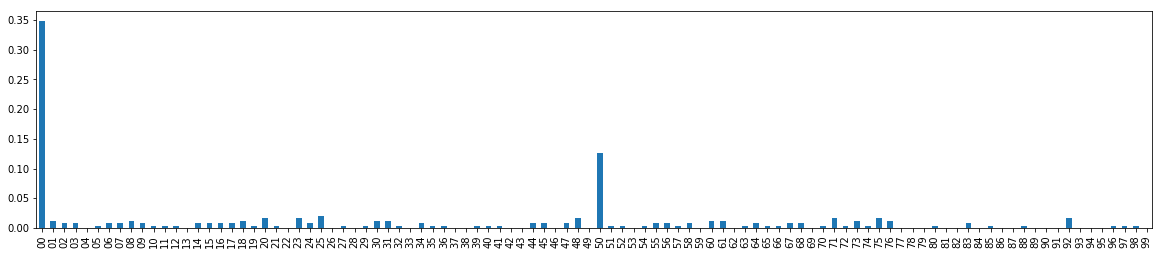

In [10]:
# Compute frequency of tip cents
n = len(df) # number of observations in the data, pre-compute rather than compute within loop
D = {}
for i in range(100):
    cents = str(i).zfill(2) # Adds leading zero for single-digit cents
    D[cents] = df['tip'].map(lambda t: '%.2f' % t).str.contains('\.' + cents).sum() / n
tip_freq = pd.Series(D)
tip_freq.plot(kind='bar', figsize=(20,4));

Aside from the \\$.00 and \\$.50 cases, why is there so much variation in the tip in cents??

### 5-Minute Activity

Analyze the tips data to develop an assessment of customer tendencies in determining the amount to tip.

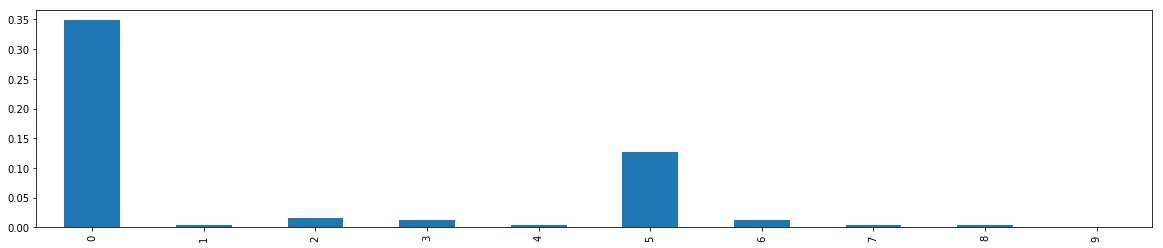

In [14]:
# Compute frequency of tip cents
n = len(df) # number of observations in the data, pre-compute rather than compute within loop
D = {}
for i in range(10):
    cents = str(i) # Adds leading zero for single-digit cents
    D[cents] = df['tip'].map(lambda t: '%.2f' % t).str.contains('\.' + cents + '0').sum() / n
tip_freq = pd.Series(D)
tip_freq.plot(kind='bar', figsize=(20,4));

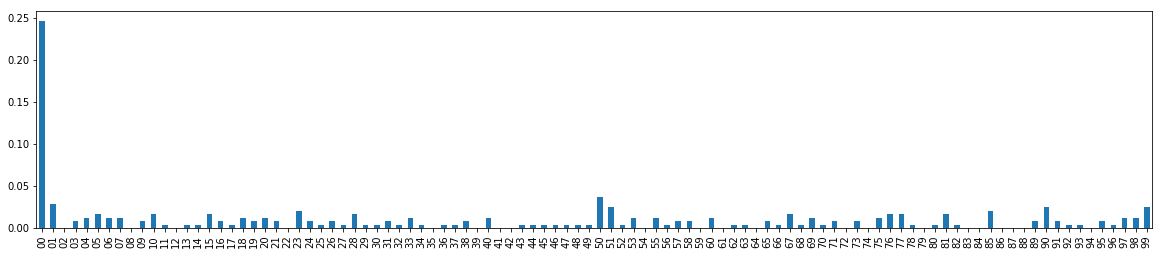

In [15]:
# Compute frequency of tip cents
n = len(df) # number of observations in the data, pre-compute rather than compute within loop
D = {}
for i in range(100):
    cents = str(i).zfill(2) # Adds leading zero for single-digit cents
    D[cents] = (df['total_bill'] + df['tip']).map(lambda t: '%.2f' % t).str.contains('\.' + cents).sum() / n
tip_freq = pd.Series(D)
tip_freq.plot(kind='bar', figsize=(20,4));

### OK, back to group operations and data transformation...

Now, suppose we wanted to analyze the tip percentage of each bill, as a function of the day of the week. We can use our newly developed .groupby operations and data aggregation skills!

In [16]:
# Method 1 - Perform the groupby operation directly on the tip_pct column (Series)
df['tip_pct'].groupby(by=df['day']).describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
Fri,19.0,16.991303,4.766531,10.355540,13.373871,15.562472,19.663729,26.348039
Sat,87.0,15.315172,5.129259,3.563814,12.386329,15.183246,18.827082,32.573290
Sun,76.0,16.689729,8.473889,5.944673,11.998208,16.110332,18.788908,71.034483
Thur,62.0,16.127563,3.865182,7.296137,13.820958,15.384615,19.268675,26.631158


In [17]:
# Revised Method 1 - Perform the groupby operation directly on the tip_pct column (Series)
day_order = ['Thur','Fri','Sat','Sun']
df['tip_pct'].groupby(by=df['day']).describe().loc[day_order]

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
Thur,62.0,16.127563,3.865182,7.296137,13.820958,15.384615,19.268675,26.631158
Fri,19.0,16.991303,4.766531,10.355540,13.373871,15.562472,19.663729,26.348039
Sat,87.0,15.315172,5.129259,3.563814,12.386329,15.183246,18.827082,32.573290
Sun,76.0,16.689729,8.473889,5.944673,11.998208,16.110332,18.788908,71.034483


In [18]:
# Method 2 - Perform the groupby operation on the entire data frame, then select the tip_pct column
df.groupby(by='day')['tip_pct'].describe().loc[day_order]

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
Thur,62.0,16.127563,3.865182,7.296137,13.820958,15.384615,19.268675,26.631158
Fri,19.0,16.991303,4.766531,10.355540,13.373871,15.562472,19.663729,26.348039
Sat,87.0,15.315172,5.129259,3.563814,12.386329,15.183246,18.827082,32.573290
Sun,76.0,16.689729,8.473889,5.944673,11.998208,16.110332,18.788908,71.034483


Let's dig into the details about the bills with the largest tips (by percentage). Let's define a function that will help us select the *n* bills with the highest tip percentage.

In [19]:
def top(frame, n=5, column='tip_pct'):
    return frame.sort_values(by=column, ascending=False).head(n)

In [20]:
# Report top 5 bills according to tip_pct
top(df)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
172,7.25,5.15,Male,Yes,Sun,Dinner,2,71.034483
178,9.60,4.00,Female,Yes,Sun,Dinner,2,41.666667
67,3.07,1.00,Female,Yes,Sat,Dinner,1,32.573290
232,11.61,3.39,Male,No,Sat,Dinner,2,29.198966
183,23.17,6.50,Male,Yes,Sun,Dinner,4,28.053517


In [21]:
# Report top 10 bills according to the bill total
top(df, n=10, column='total_bill')

,total_bill,tip,sex,smoker,day,time,size,tip_pct
170,50.81,10.00,Male,Yes,Sat,Dinner,3,19.681165
212,48.33,9.00,Male,No,Sat,Dinner,4,18.621974
59,48.27,6.73,Male,No,Sat,Dinner,4,13.942407
156,48.17,5.00,Male,No,Sun,Dinner,6,10.379905
182,45.35,3.50,Male,Yes,Sun,Dinner,3,7.717751
102,44.30,2.50,Female,Yes,Sat,Dinner,3,5.643341
197,43.11,5.00,Female,Yes,Thur,Lunch,4,11.598237
142,41.19,5.00,Male,No,Thur,Lunch,5,12.138869
184,40.55,3.00,Male,Yes,Sun,Dinner,2,7.398274
95,40.17,4.73,Male,Yes,Fri,Dinner,4,11.774956


Now, let's apply our top function to some GroupBy objects:

In [22]:
# Highest tip_pct for each day (can pass the argument from fuction, 'top', into apply())
df.groupby(by='day').apply(top, n=1) # .apply method accepts *args and **kwargs

,,total_bill,tip,sex,smoker,day,time,size,tip_pct
day,,,,,,,,,
Fri,93,16.32,4.30,Female,Yes,Fri,Dinner,2,26.348039
Sat,67,3.07,1.00,Female,Yes,Sat,Dinner,1,32.573290
Sun,172,7.25,5.15,Male,Yes,Sun,Dinner,2,71.034483
Thur,149,7.51,2.00,Male,No,Thur,Lunch,2,26.631158


In [25]:
# Drop index values and re-order
df.groupby(by='day').apply(top, n=1).reset_index(level=1, drop=True).loc[day_order]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
day,,,,,,,,
Thur,7.51,2.00,Male,No,Thur,Lunch,2,26.631158
Fri,16.32,4.30,Female,Yes,Fri,Dinner,2,26.348039
Sat,3.07,1.00,Female,Yes,Sat,Dinner,1,32.573290
Sun,7.25,5.15,Male,Yes,Sun,Dinner,2,71.034483


In [26]:
# Highest total_bill by time of day
df.groupby(by='time').apply(top, column='total_bill').reset_index(1, drop=True).loc[['Lunch','Dinner']]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
time,,,,,,,,
Lunch,43.11,5.00,Female,Yes,Thur,Lunch,4,11.598237
Lunch,41.19,5.00,Male,No,Thur,Lunch,5,12.138869
Lunch,34.83,5.17,Female,No,Thur,Lunch,4,14.843526
Lunch,34.30,6.70,Male,No,Thur,Lunch,6,19.533528
Lunch,32.68,5.00,Male,Yes,Thur,Lunch,2,15.299878
Dinner,50.81,10.00,Male,Yes,Sat,Dinner,3,19.681165
Dinner,48.33,9.00,Male,No,Sat,Dinner,4,18.621974
Dinner,48.27,6.73,Male,No,Sat,Dinner,4,13.942407
Dinner,48.17,5.00,Male,No,Sun,Dinner,6,10.379905


Now, suppose we want to analyze the relationship between some of the other factors and tip_pct.

In [27]:
df['tip_pct'].groupby(by=df['sex']).mean()

sex
Female    16.649074
Male      15.765055
Name: tip_pct, dtype: float64

In [28]:
df['tip_pct'].groupby(by=df['day']).mean().loc[day_order]

day
Thur    16.127563
Fri     16.991303
Sat     15.315172
Sun     16.689729
Name: tip_pct, dtype: float64

In [29]:
df['tip_pct'].groupby(by=df['time']).mean()

time
Dinner    15.951779
Lunch     16.412793
Name: tip_pct, dtype: float64

In [30]:
df.groupby(by=['day','time'])['tip_pct'].mean()

day   time  
Fri   Dinner    15.891611
      Lunch     18.876489
Sat   Dinner    15.315172
Sun   Dinner    16.689729
Thur  Dinner    15.974441
      Lunch     16.130074
Name: tip_pct, dtype: float64

### Quick Review

How could we reshape the previous result so that it is easier to view the results?

In [31]:
df.groupby(by=['day','time'])['tip_pct'].mean().to_frame()

tip_pct
day  time             
Fri  Dinner  15.891611
     Lunch   18.876489
Sat  Dinner  15.315172
Sun  Dinner  16.689729
Thur Dinner  15.974441
     Lunch   16.130074

In [32]:
df.groupby(by=['day','time'])['tip_pct'].mean().unstack()

time,Dinner,Lunch
day,,
Fri,15.891611,18.876489
Sat,15.315172,NaN
Sun,16.689729,NaN
Thur,15.974441,16.130074


In [34]:
df.groupby(by=['day','time'])['tip_pct'].mean().unstack(0).loc[['Lunch','Dinner'], day_order]

day,Thur,Fri,Sat,Sun
time,,,,
Lunch,16.130074,18.876489,NaN,NaN
Dinner,15.974441,15.891611,15.315172,16.689729


# OK, let's resume...

Perhaps the relationship between one factor and tip_pct depends on another factor...

In [35]:
df['total_bill'].corr(df['tip_pct'])

-0.3386240849647348

In [36]:
df.groupby(by='day')[['total_bill','tip','size']].apply(lambda g: g.corrwith(df['tip_pct'])).loc[day_order]

,total_bill,tip,size
day,,,
Thur,-0.267903,0.300406,-0.085624
Fri,-0.478875,0.152047,-0.288477
Sat,-0.286110,0.389373,-0.197667
Sun,-0.430747,0.401011,-0.159900


### Pivot Tables and Cross Tabulations

An alternative approach to applying GroupBy aggregation functions is available in the form of the .pivot_table method (also available as pd.pivot_table), which is similar to the Pivot Table functionality in Excel. Essentially, pivot tables in Python are a combination of GroupBy operations, data aggregation, reshaping, and possibly hierarchical indexing all combined into a single method (or function) for convenience.

Let's revisit our analysis of tip_pct as a function of day of the week and time of the day:

In [37]:
# GroupBy approach
df.groupby(by=['day','time'])['tip_pct'].mean().unstack()

time,Dinner,Lunch
day,,
Fri,15.891611,18.876489
Sat,15.315172,NaN
Sun,16.689729,NaN
Thur,15.974441,16.130074


In [38]:
# Pivot table approach
df.pivot_table(values='tip_pct', index='day', columns='time', aggfunc='mean')

time,Dinner,Lunch
day,,
Fri,15.891611,18.876489
Sat,15.315172,NaN
Sun,16.689729,NaN
Thur,15.974441,16.130074


In [39]:
# Adding margins to pivot table
df.pivot_table(values='tip_pct', index='day', columns='time', aggfunc='mean', margins=True)

time,Dinner,Lunch,All
day,,,
Fri,15.891611,18.876489,16.991303
Sat,15.315172,NaN,15.315172
Sun,16.689729,NaN,16.689729
Thur,15.974441,16.130074,16.127563
All,15.951779,16.412793,16.080258


In [40]:
# Including multiple sets of values to pivot table
df.pivot_table(values=['total_bill','tip','size','tip_pct'], index=['day','time'], aggfunc='mean', margins=True)

size       tip    tip_pct  total_bill
day  time                                             
Fri  Dinner  2.166667  2.940000  15.891611   19.663333
     Lunch   2.000000  2.382857  18.876489   12.845714
Sat  Dinner  2.517241  2.993103  15.315172   20.441379
Sun  Dinner  2.842105  3.255132  16.689729   21.410000
Thur Dinner  2.000000  3.000000  15.974441   18.780000
     Lunch   2.459016  2.767705  16.130074   17.664754
All          2.569672  2.998279  16.080258   19.785943

In [41]:
# Including multiple sets of values and aggregation functions to pivot table
df.pivot_table(values=['total_bill','tip','size','tip_pct'], index=['day','time'], aggfunc=['min','mean','max'], margins=True)

min                                  mean                       \
            size   tip    tip_pct total_bill      size       tip    tip_pct   
day  time                                                                     
Fri  Dinner    2  1.00  10.355540       5.75  2.166667  2.940000  15.891611   
     Lunch     1  1.58  11.773472       8.58  2.000000  2.382857  18.876489   
Sat  Dinner    1  1.00   3.563814       3.07  2.517241  2.993103  15.315172   
Sun  Dinner    2  1.01   5.944673       7.25  2.842105  3.255132  16.689729   
Thur Dinner    2  3.00  15.974441      18.78  2.000000  3.000000  15.974441   
     Lunch     1  1.25   7.296137       7.51  2.459016  2.767705  16.130074   
All            1  1.00   3.563814       3.07  2.569672  2.998279  16.080258   

                        max                               
            total_bill size    tip    tip_pct total_bill  
day  time                                                 
Fri  Dinner  19.663333    4   4.73  26.348039      40.17  
     Lunch   12.845714    3   3.48  25.931446      16.27  
Sat  Dinner  20.441379    5  10.00  32.573290      50.81  
Sun  Dinner  21.410000    6   6.50  71.034483      48.17  
Thur Dinner  18.780000    2   3.00  15.974441      18.78  
     Lunch   17.664754    6   6.70  26.631158      43.11  
All          19.785943    6  10.00  71.034483      50.81

In [42]:
# Including multiple sets of values and aggregation functions to pivot table - Reorganized (swaplevel)
df.pivot_table(values=['total_bill','tip','size','tip_pct'], index=['day','time'], aggfunc=['min','mean','max'], margins=True).swaplevel(axis=1).sort_index(ascending=False, axis=1)

total_bill                      tip_pct                        \
                   min       mean    max        min       mean        max   
day  time                                                                   
Fri  Dinner       5.75  19.663333  40.17  10.355540  15.891611  26.348039   
     Lunch        8.58  12.845714  16.27  11.773472  18.876489  25.931446   
Sat  Dinner       3.07  20.441379  50.81   3.563814  15.315172  32.573290   
Sun  Dinner       7.25  21.410000  48.17   5.944673  16.689729  71.034483   
Thur Dinner      18.78  18.780000  18.78  15.974441  15.974441  15.974441   
     Lunch        7.51  17.664754  43.11   7.296137  16.130074  26.631158   
All               3.07  19.785943  50.81   3.563814  16.080258  71.034483   

              tip                  size                
              min      mean    max  min      mean max  
day  time                                              
Fri  Dinner  1.00  2.940000   4.73    2  2.166667   4  
     Lunch   1.58  2.382857   3.48    1  2.000000   3  
Sat  Dinner  1.00  2.993103  10.00    1  2.517241   5  
Sun  Dinner  1.01  3.255132   6.50    2  2.842105   6  
Thur Dinner  3.00  3.000000   3.00    2  2.000000   2  
     Lunch   1.25  2.767705   6.70    1  2.459016   6  
All          1.00  2.998279  10.00    1  2.569672   6

A cross tabulation (or crosstab for short) is just a special case of a pivot table, for which the aggregation function is count (by default). The pd.crosstab method is more flexible than this specific case, but in general, the pivot table method should suffice for similar types of analysis.

In [43]:
# Count frequency of bills as a function of day and time (count the sample size of each category)
pd.crosstab(index=df.day, columns=df.time, margins=True) # crosstabl is a function of pandas not method of dataframe

time,Dinner,Lunch,All
day,,,
Fri,12,7,19
Sat,87,0,87
Sun,76,0,76
Thur,1,61,62
All,176,68,244


## Next Week: Guest Speaker and Time Series Data